# Zero Inflated Sales AB Test

## Import Libraries & Create Data

In [1]:
# Import Libraries
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
from dowhy import CausalModel
import dowhy.datasets
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Define the number of rows in the dataset
num_rows = 1000

# Generate customer IDs
customer_ids = np.arange(1, num_rows + 1)

# Generate website versions (50/50 split)
website_versions = np.random.choice(['Version A', 'Version B'], size=num_rows, p=[0.5, 0.5])
website_versions_bin = np.where(website_versions == 'Version A', 0, 1)

# Generate sales amounts (right-skewed from $10 to $1000)
sales = np.random.lognormal(mean=np.log(100), sigma=1, size=num_rows)

# Generate the number of visits in the past 6 months (Poisson distribution with lambda=10)
visits_past_6_months = np.random.poisson(lam=10, size=num_rows)

# Create a DataFrame
df = pd.DataFrame({
    'CustomerID': customer_ids,
    'WebsiteVersion': website_versions,
    'Sales': sales,
    'VisitsPast6Months': visits_past_6_months
})

# Display the first few rows of the DataFrame
df.head()


,CustomerID,WebsiteVersion,Sales,VisitsPast6Months
0,1,Version A,119.446812,10
1,2,Version B,26.306757,11
2,3,Version B,146.257393,7
3,4,Version B,184.150974,7
4,5,Version A,175.030568,5


## Bayesian Inference using PYMC

In [3]:
# Define the observed sales data for each website version
sales_version_A = df[df['WebsiteVersion'] == 'Version A']['Sales'].values
sales_version_B = df[df['WebsiteVersion'] == 'Version B']['Sales'].values

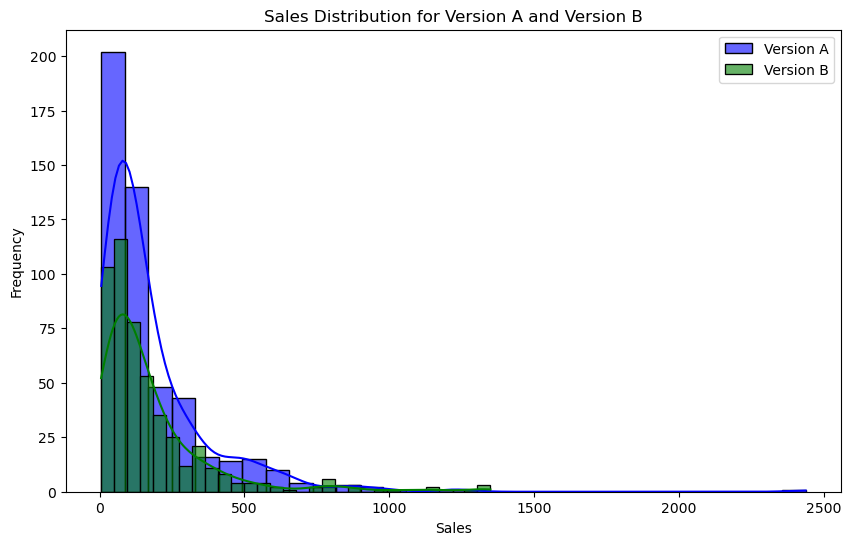

In [4]:
# Plot overlapping histograms
plt.figure(figsize=(10, 6))

sns.histplot(sales_version_A, bins=30, kde=True, color='blue', label='Version A', alpha=0.6)
sns.histplot(sales_version_B, bins=30, kde=True, color='green', label='Version B', alpha=0.6)

plt.title('Sales Distribution for Version A and Version B')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.legend()

plt.show()

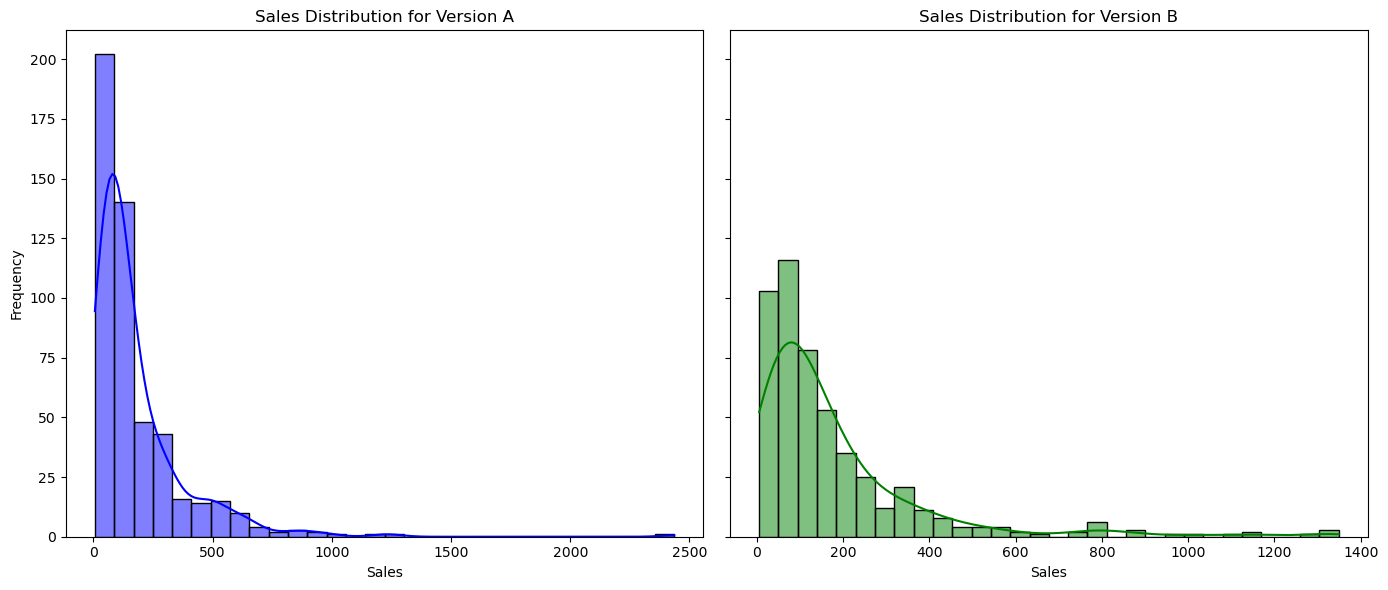

In [5]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot histograms
sns.histplot(sales_version_A, bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Sales Distribution for Version A')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')

sns.histplot(sales_version_B, bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Sales Distribution for Version B')
axes[1].set_xlabel('Sales')

plt.tight_layout()
plt.show()

In [6]:
# PyMC model for zero-inflated Poisson distribution
with pm.Model() as model:
    # Priors for Poisson rate (lambda)
    lambda_A = pm.Exponential('lambda_A', lam=1/np.mean(sales_version_A[sales_version_A > 0]))
    lambda_B = pm.Exponential('lambda_B', lam=1/np.mean(sales_version_B[sales_version_B > 0]))
    
    # Priors for zero-inflation probabilities
    psi_A = pm.Beta('psi_A', alpha=1, beta=1)
    psi_B = pm.Beta('psi_B', alpha=1, beta=1)
    
    # Zero-inflated Poisson components
    zip_A = pm.ZeroInflatedPoisson('zip_A', psi=psi_A, mu=lambda_A, observed=sales_version_A)
    zip_B = pm.ZeroInflatedPoisson('zip_B', psi=psi_B, mu=lambda_B, observed=sales_version_B)
    
    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_A, lambda_B, psi_A, psi_B]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
# Summarize the trace
summary = az.summary(trace)
print(summary)

             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda_A  178.561  0.592  177.466  179.646      0.011    0.008    2999.0   
lambda_B  176.822  0.602  175.727  177.972      0.010    0.007    3396.0   
psi_A       0.998  0.002    0.994    1.000      0.000    0.000    2391.0   
psi_B       0.998  0.002    0.994    1.000      0.000    0.000    2858.0   

          ess_tail  r_hat  
lambda_A    2696.0    1.0  
lambda_B    2920.0    1.0  
psi_A       1540.0    1.0  
psi_B       2147.0    1.0  


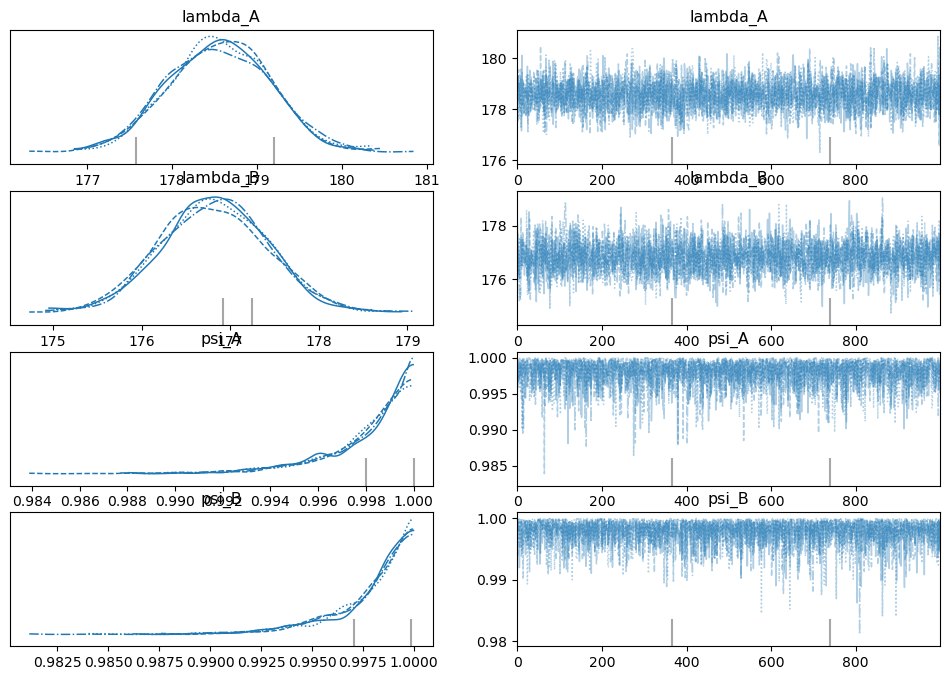

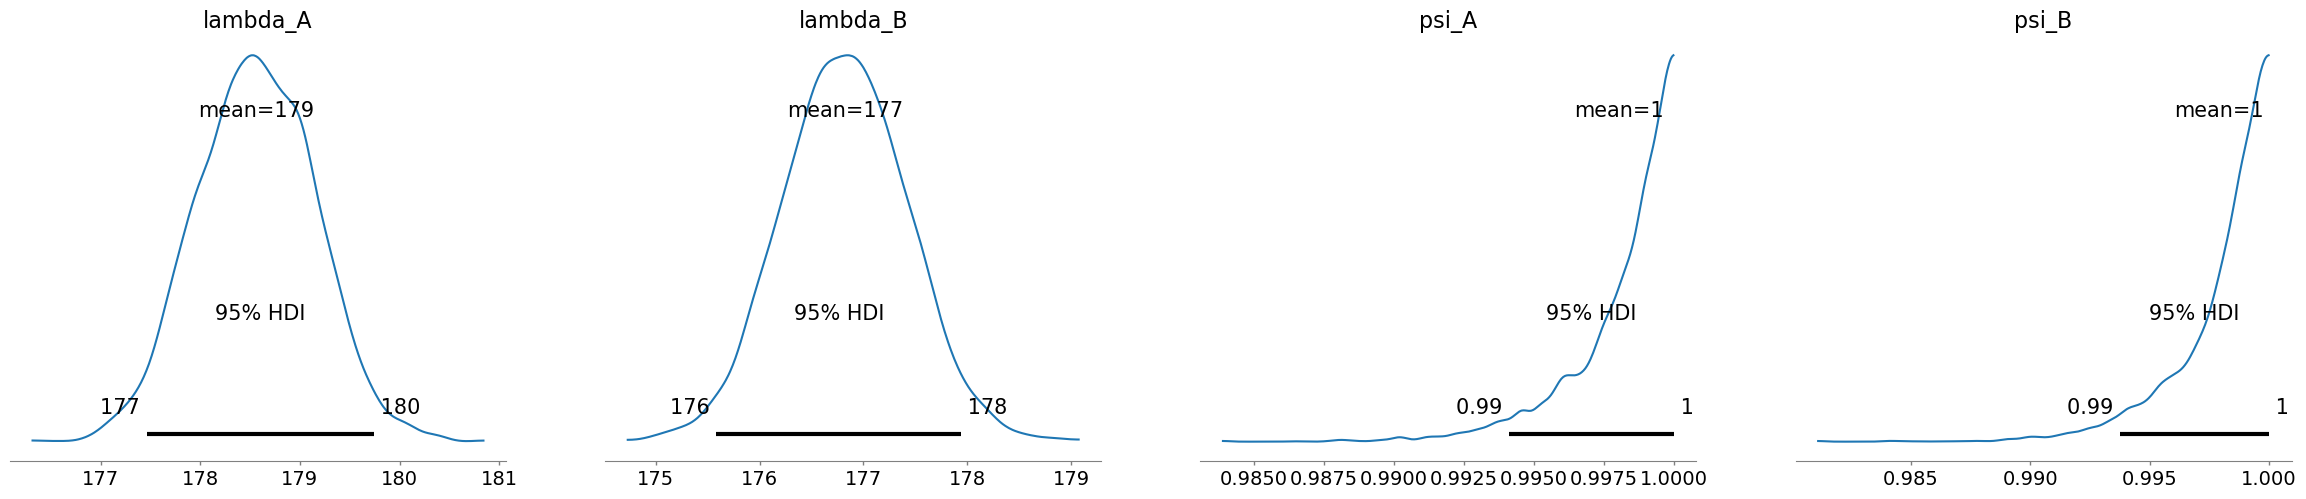

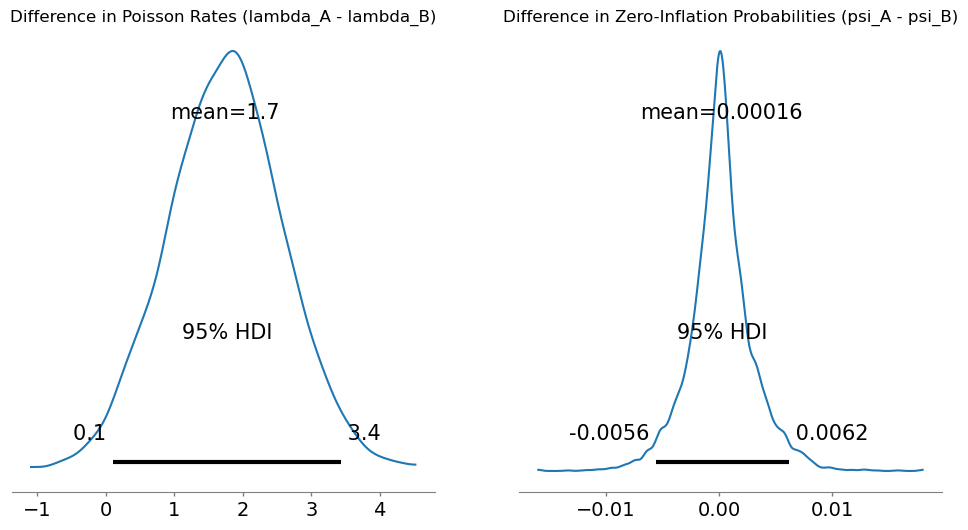

In [8]:
# Plot posterior distributions
az.plot_trace(trace, var_names=['lambda_A', 'lambda_B', 'psi_A', 'psi_B'])
plt.show()

# Plot posterior densities
az.plot_posterior(trace, var_names=['lambda_A', 'lambda_B', 'psi_A', 'psi_B'], hdi_prob=0.95)
plt.show()

# Calculate and plot the difference in lambda
lambda_diff = trace.posterior['lambda_A'] - trace.posterior['lambda_B']
psi_diff = trace.posterior['psi_A'] - trace.posterior['psi_B']

# Plot the posterior distributions of the differences
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

az.plot_posterior(lambda_diff, hdi_prob=0.95, ax=axes[0])
axes[0].set_title('Difference in Poisson Rates (lambda_A - lambda_B)')

az.plot_posterior(psi_diff, hdi_prob=0.95, ax=axes[1])
axes[1].set_title('Difference in Zero-Inflation Probabilities (psi_A - psi_B)')

plt.show()

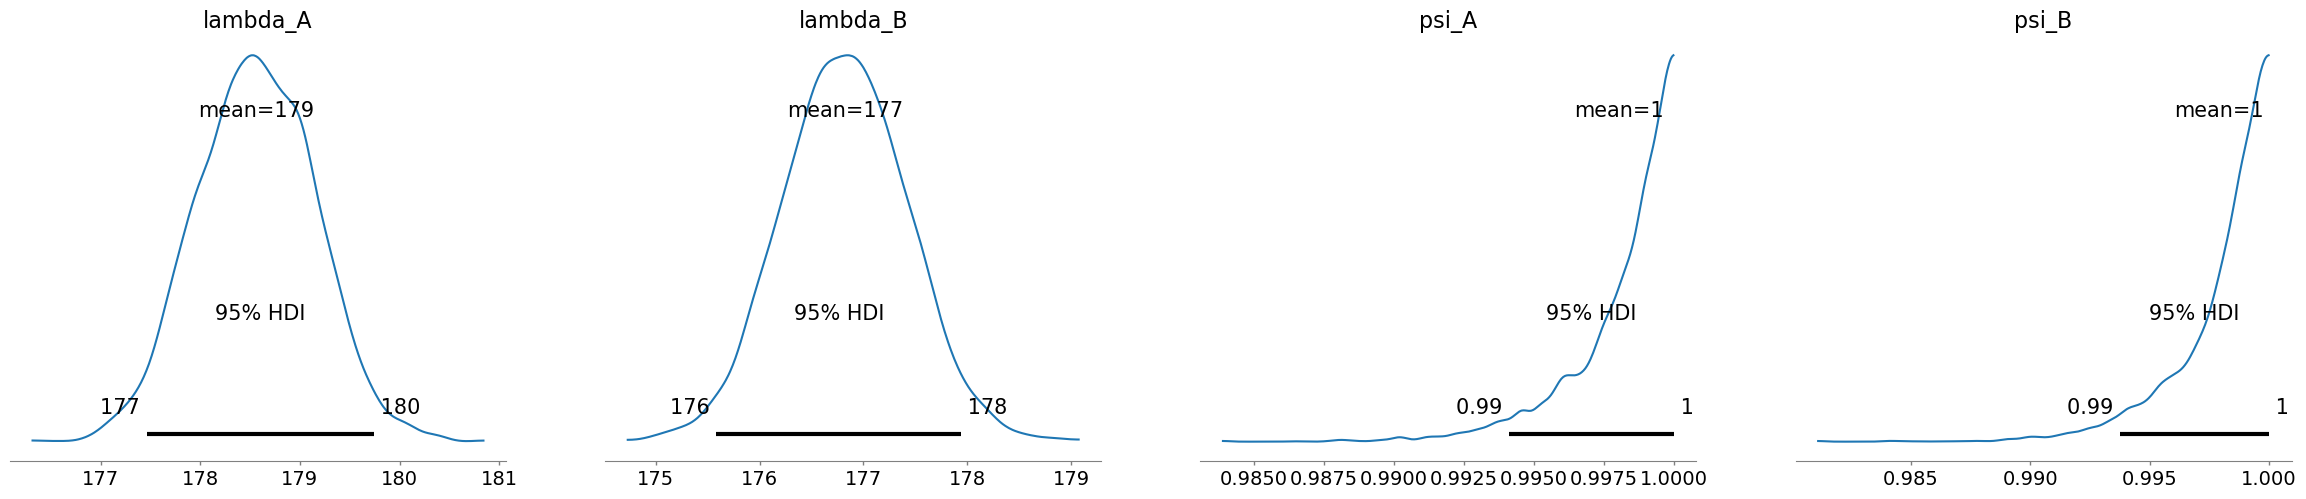

<Figure size 1000x600 with 0 Axes>

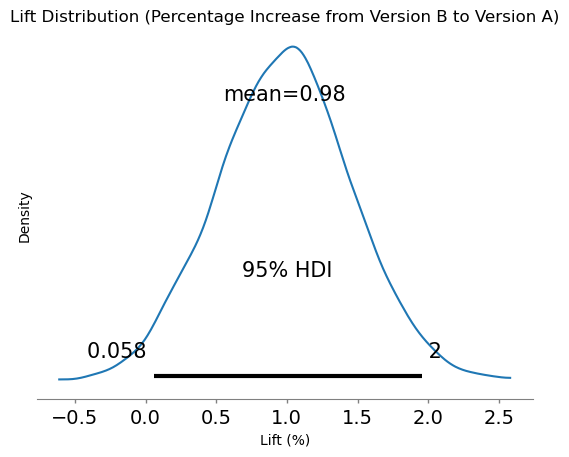

<Figure size 1000x600 with 0 Axes>

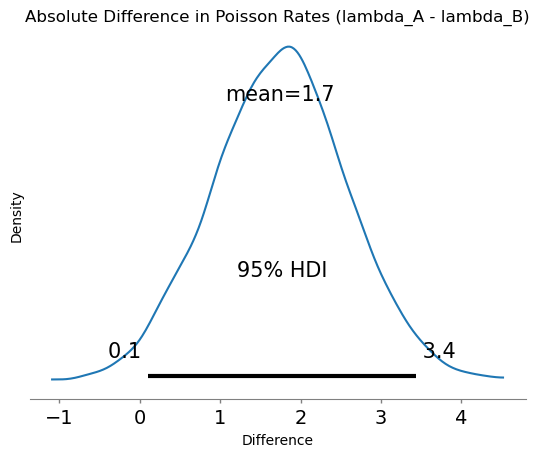

Probability that Version A has a higher Poisson rate than Version B: 0.98


In [9]:
# Assuming `trace` is the result of the sampling process from the previous model
# Visualize the posterior distributions
az.plot_posterior(trace, var_names=['lambda_A', 'lambda_B', 'psi_A', 'psi_B'], hdi_prob=0.95)
plt.show()

# Calculate the lift
lambda_A_samples = trace.posterior['lambda_A'].values.flatten()
lambda_B_samples = trace.posterior['lambda_B'].values.flatten()
lift = (lambda_A_samples - lambda_B_samples) / lambda_B_samples * 100

# Calculate the absolute difference
absolute_diff = lambda_A_samples - lambda_B_samples

# Calculate the probability that the distributions come from different data generating processes
prob_diff_process = np.mean(lambda_A_samples > lambda_B_samples)

# Plot the lift
plt.figure(figsize=(10, 6))
az.plot_posterior(lift, hdi_prob=0.95)
plt.title('Lift Distribution (Percentage Increase from Version B to Version A)')
plt.xlabel('Lift (%)')
plt.ylabel('Density')
plt.show()

# Plot the absolute difference
plt.figure(figsize=(10, 6))
az.plot_posterior(absolute_diff, hdi_prob=0.95)
plt.title('Absolute Difference in Poisson Rates (lambda_A - lambda_B)')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.show()

# Print the probability that the distributions come from different processes
print(f"Probability that Version A has a higher Poisson rate than Version B: {prob_diff_process:.2f}")


## Causal Inference using DoWhy

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         1000 non-null   int32  
 1   WebsiteVersion     1000 non-null   int32  
 2   Sales              1000 non-null   float64
 3   VisitsPast6Months  1000 non-null   int32  
dtypes: float64(1), int32(3)
memory usage: 19.7 KB


In [4]:
# Define the causal model
model = CausalModel(
    data=df,
    treatment='WebsiteVersion',
    outcome='Sales',
    common_causes=['VisitsPast6Months']  # Include any other covariates
)

In [5]:
# Identify the causal effect
identified_estimand = model.identify_effect()

In [6]:
# Estimate the causal effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

c:\Users\wallj\anaconda3\envs\pymc_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [7]:
# Refute the estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)

c:\Users\wallj\anaconda3\envs\pymc_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\wallj\anaconda3\envs\pymc_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\wallj\anaconda3\envs\pymc_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

In [8]:
# Print results
print("Causal Estimate:", estimate)
print("Refutation:", refutation)

Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                    
─────────────────(E[Sales|VisitsPast6Months])
d[WebsiteVersion]                            
Estimand assumption 1, Unconfoundedness: If U→{WebsiteVersion} and U→Sales then P(Sales|WebsiteVersion,VisitsPast6Months,U) = P(Sales|WebsiteVersion,VisitsPast6Months)

## Realized estimand
b: Sales~WebsiteVersion+VisitsPast6Months
Target units: ate

## Estimate
Mean value: -1.9203713327823664

Refutation: Refute: Use a Placebo Treatment
Estimated effect:-1.9203713327823664
New effect:-0.2782316313735461
p value:0.94

